In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conv0_k1 = torch.zeros(8, 15, 15)
conv0_k1[0] += 1.0
conv0_k1[4] -= 1.0
conv0_k2 = torch.zeros(8, 15, 15)
conv0_k2[1] += 1.0
conv0_k2[5] -= 1.0
conv0_k3 = torch.zeros(8, 15, 15)
conv0_k3[2] += 1.0
conv0_k3[6] -= 1.0
conv0_k4 = torch.zeros(8, 15, 15)
conv0_k4[3] += 1.0
conv0_k4[7] -= 1.0
conv0_weight = torch.stack([conv0_k1, conv0_k2, conv0_k3, conv0_k4], dim = 0)

In [3]:
import sys
sys.path.append("../")
from utils import *
sys.path.append("../Google_HDRplus/")
from merge_utils import *
import matplotlib.pyplot as plt
%matplotlib inline
bk_lvl = 50
print("black level of the sensor: ", bk_lvl)

black level of the sensor:  50


In [4]:
rIm=read_raw("../static_videos/lowlight3_frame16_bunny_3.raw", frame =16)
rIm = rIm[:, :2048, :3584]

In [5]:
ref = rIm[0]
alt = np.load('../flow_test/warped_npys_lowlight3_bunny3/warped_15.npy')

assert ref.shape == alt.shape
assert ref.dtype == alt.dtype

In [6]:
ref = np.clip(ref - bk_lvl, 0, 1023)
ref = ref/ref.max()
alt = np.clip(alt - bk_lvl, 0, 1023)
alt = alt/alt.max()
print_stat("ref", ref)
print_stat("alt", alt)

ref shape:  (2048, 3584) dtype: float64
ref stat: max: 1.0, min: 0.0, mean: 0.24254565264182124, std: 0.1324669849117804
alt shape:  (2048, 3584) dtype: float64
alt stat: max: 1.0, min: 0.0, mean: 0.21081617900303443, std: 0.12396576741106077


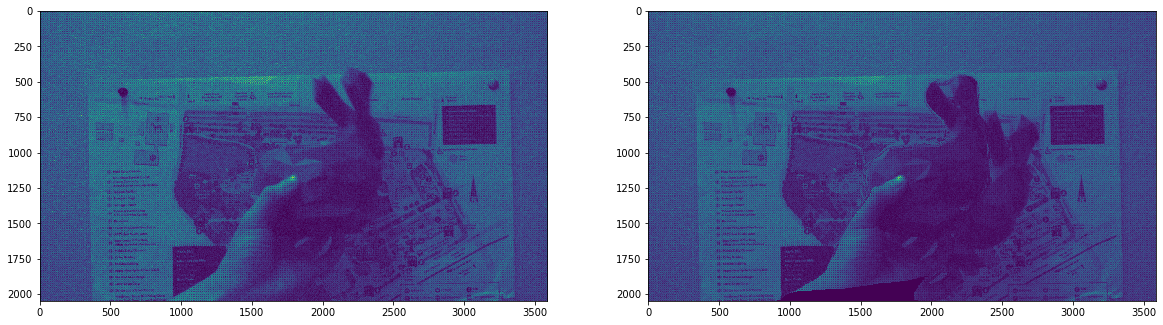

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(ref)
ax[1].imshow(alt)
plt.show()

In [8]:
ref_stack = raw_to_stack(ref)
alt_stack = raw_to_stack(alt)

In [9]:
ref_t = torch.from_numpy(ref_stack.copy().transpose(2, 0, 1))
alt_t = torch.from_numpy(alt_stack.copy().transpose(2, 0, 1))

In [10]:
inputs = torch.cat([ref_t, alt_t], dim = 0).unsqueeze(0)
inputs.size()

torch.Size([1, 8, 1024, 1792])

In [11]:
outputs = F.conv2d(inputs.float(), conv0_weight.float(), padding = 7)
outputs = torch.sum(torch.abs(outputs), dim = 1, keepdim=True)

In [12]:
outputs.shape

torch.Size([1, 1, 1024, 1792])

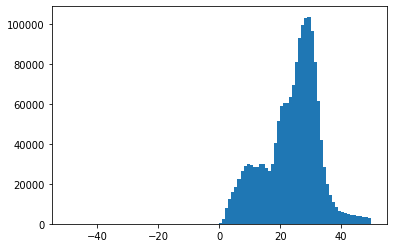

In [13]:
plt.hist(outputs.view(-1).numpy(), 100, range=(-50, 50))
plt.show()

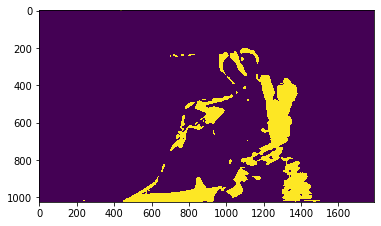

In [14]:
output = outputs.view(1024, -1).numpy()
plt.imshow(output > 45)
plt.show()

In [15]:
class SimpleMergeNet(nn.Module):
    
    def __init__(self):
        super(SimpleMergeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(8, 4, 15, padding = 7, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(8, 4, 15, padding = 7, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(8, 1, 1, bias=True)
        
        self.load_state_dict(torch.load('SimpleMergeNet.pth'))
        
    def forward(self, x):

        out1 = self.relu1(self.conv1(x))
        out2 = self.relu2(self.conv2(x))
        out = torch.cat([out1, out2], dim = 1)
        out = self.conv3(out)
        out = torch.sigmoid(out)
        out = out.repeat(1, 4, 1, 1)
        out = out * x[:, :4] + (1 - out) * x[:, 4:]
        
        return out

In [16]:
model = SimpleMergeNet()

In [17]:
conv0_k1 = torch.zeros(8, 15, 15)
conv0_k1[0] += 1.0
conv0_k1[4] -= 1.0
conv0_k2 = torch.zeros(8, 15, 15)
conv0_k2[1] += 1.0
conv0_k2[5] -= 1.0
conv0_k3 = torch.zeros(8, 15, 15)
conv0_k3[2] += 1.0
conv0_k3[6] -= 1.0
conv0_k4 = torch.zeros(8, 15, 15)
conv0_k4[3] += 1.0
conv0_k4[7] -= 1.0
conv1_weight = torch.stack([conv0_k1, conv0_k2, conv0_k3, conv0_k4], dim = 0)

In [18]:
conv2_weight = -torch.stack([conv0_k1, conv0_k2, conv0_k3, conv0_k4], dim = 0)

In [19]:
conv2_weight.shape

torch.Size([4, 8, 15, 15])

In [20]:
conv3_weight = torch.ones(1, 8, 1, 1)

In [21]:
conv3_bias = -torch.ones(1) *40.

In [39]:
model.conv1.weight = torch.nn.Parameter(conv1_weight + 0.05*torch.randn_like(conv1_weight))

In [40]:
model.conv2.weight = torch.nn.Parameter(conv2_weight+ 0.05*torch.randn_like(conv2_weight))

In [41]:
model.conv3.weight = torch.nn.Parameter(conv3_weight + 0.05*torch.randn_like(conv3_weight))

In [42]:
model.conv3.bias = torch.nn.Parameter(conv3_bias)

In [43]:
model.conv1.bias = torch.nn.Parameter(torch.zeros_like(model.conv1.bias.data))

In [44]:
model.conv2.bias = torch.nn.Parameter(torch.zeros_like(model.conv2.bias.data))

In [45]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
torch.save(model.state_dict(), 'SimpleMergeNet.pth')

Model's state_dict:
conv1.weight 	 torch.Size([4, 8, 15, 15])
conv1.bias 	 torch.Size([4])
conv2.weight 	 torch.Size([4, 8, 15, 15])
conv2.bias 	 torch.Size([4])
conv3.weight 	 torch.Size([1, 8, 1, 1])
conv3.bias 	 torch.Size([1])


In [46]:
model.conv3.bias.data

tensor([-40.])

In [47]:
inputs.size()

torch.Size([1, 8, 1024, 1792])

In [48]:
outputs = model(inputs.float())

In [49]:
outputs.size()

torch.Size([1, 4, 1024, 1792])

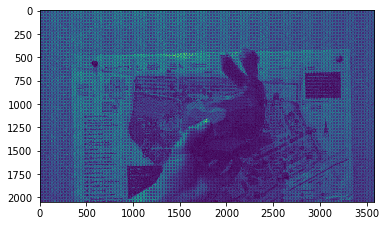

In [50]:
img = outputs[0].detach().numpy()
img = stack_to_raw(img.transpose(1, 2, 0))
plt.imshow(img)
plt.show()

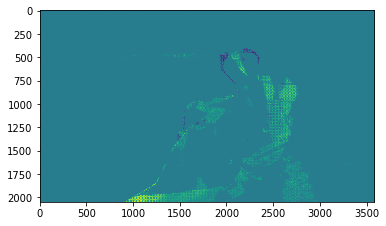

In [51]:
plt.imshow(img-alt)
plt.show()

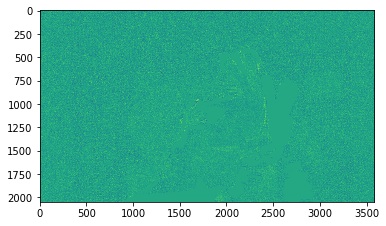

In [52]:
plt.imshow(img-ref)
plt.show()